In [1]:
import numpy as np
import pandas as pd
import warnings
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from re import sub
from collections import Counter

warnings.filterwarnings('ignore')

In [2]:
# model packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from scipy.optimize import minimize

In [3]:
df = pd.read_csv('data/calendar_compiled.csv')
df_calendar = df.drop(['Unnamed: 0'], axis =1)
df_listing = pd.read_csv('data/listings_complete.csv')

##  EDA

1. Data Cleaning: Type Conversion

In [4]:
# convert time info
df_calendar['date'] = pd.to_datetime(df_calendar['date'], format='%Y%m%d') 
df_calendar['dayWeek'] = df_calendar['date'].dt.day_name()
df_calendar['year'] = df_calendar['date'].dt.year
df_calendar['month'] = df_calendar['date'].dt.month
df_calendar['day'] = df_calendar['date'].dt.day

df_listing['host_since'] = pd.to_datetime(df_listing['host_since'])

In [5]:
# change price columns
price_columns = ['price', 'weekly_price', 'monthly_price','security_deposit', 'cleaning_fee',  'extra_people']
for price in price_columns:
    df_listing[price] = df_listing[price].apply(lambda x:  x if (x != x) else float(sub(r'[^\d.]', '', x)))

In [6]:
# zip code
df_listing['zipcode'] = df_listing.zipcode.apply(lambda x: x if (x != x) else x[-4:])

2. Data Integration: Merge according to list_id and id

In [7]:
# merge according to list_id and id
df_all = df_calendar.merge(df_listing, left_on = 'listing_id', right_on = 'id', suffixes=('_daily', '_average'))
df_all = df_all.drop(['id'], axis = 1)

In [8]:
df_all.columns

Index(['listing_id', 'date', 'city', 'price_daily', 'unavailable', 'dayWeek',
       'year', 'month', 'day', 'Unnamed: 0', 'host_since', 'zipcode',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities',
       'price_average', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'number_of_reviews',
       'review_scores_rating', 'Wifi', 'Heating', 'Smoke detector',
       'Essentials', 'Kitchen', 'Carbon monoxide detector', 'Hangers',
       'Air conditioning', 'Shampoo', 'Hair dryer', 'Iron',
       'Laptop friendly workspace', 'TV', 'Washer', 'Dryer', 'Hot water',
       'Fire extinguisher', 'Refrigerator', 'Microwave', 'Self check-in'],
      dtype='object')

3. Columns of interest

In [9]:
column_interested = ['listing_id', 'date', 'city', 'price_daily', 'unavailable', 'dayWeek', 'year', 'month', 'day', 
                     'host_since', 'zipcode', 'property_type', 'room_type', 'accommodates', 
                     'bathrooms', 'bedrooms', 'beds', 'bed_type','amenities', 'number_of_reviews',
                     'security_deposit', 'cleaning_fee','guests_included', 'extra_people']

df_clean = df_all[column_interested]

3. Missing Values and Imputation

In [10]:
df_clean.isna().sum()[df_clean.isna().sum() != 0]

host_since             245
zipcode              11409
bathrooms             1002
bedrooms               553
security_deposit    468519
cleaning_fee        237600
dtype: int64

In [11]:
impute_zero = ['security_deposit', 'cleaning_fee', 'bathrooms', 'bedrooms']
keep_nan = ['zipcode']

df_clean[impute_zero] = df_clean[impute_zero].fillna(0)

4. feature engineering

In [12]:
# create host_length (enter 0 when doing our optimization)
df_clean['host_length'] = (df_clean['date'] - df_clean['host_since']).dt.days
df_clean['host_length'] = df_clean['host_length'].fillna(0)

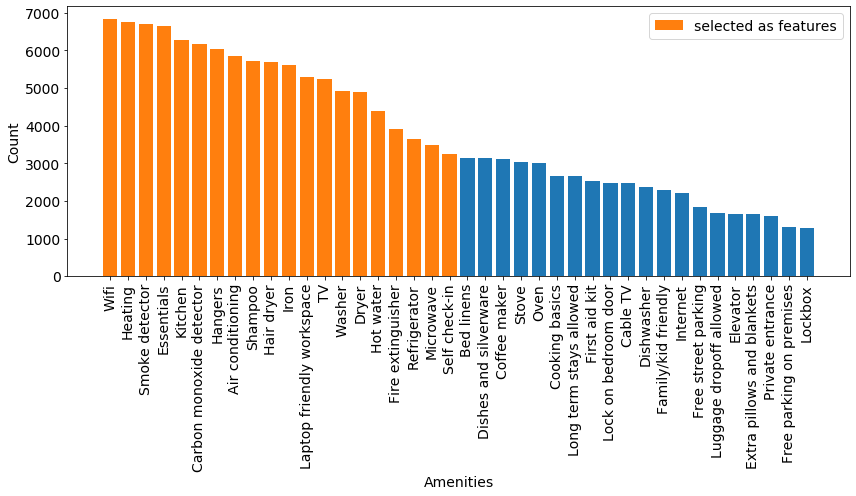

In [17]:
# extract important amenities info
# we are interested in the top 20 amenities
all_amenities = []
for amenities in df_listing.amenities: 
    list_amenities = amenities[1:-1].split(',')
    list_amenities = np.char.strip(list_amenities,'\"')
    all_amenities.extend(list_amenities)

n_amenities = 20
amenities_interest = [pair[0] for pair in Counter(all_amenities).most_common()[:n_amenities]]
amenities_interest_cnt = [pair[1] for pair in Counter(all_amenities).most_common()[:n_amenities]]

fig,ax=plt.subplots(1,1,figsize=(12,7))
plt.bar([pair[0] for pair in Counter(all_amenities).most_common()[:40]],
        [pair[1] for pair in Counter(all_amenities).most_common()[:40]])
plt.bar(amenities_interest,amenities_interest_cnt,label='selected as features')
plt.xlabel('Amenities',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('amenities.png')

In [18]:
listing_amenities = np.zeros((len(df_clean),n_amenities))

for i,row in df_clean.iterrows():
    amenities = np.char.strip(row.amenities[1:-1].split(','),'\"')
    for j,a in enumerate(amenities_interest):
        if a in amenities:
            listing_amenities[i,j] = 1

In [19]:
for i,a in enumerate(amenities_interest):
    df_clean[a] = listing_amenities[:,i]


In [20]:
df_clean = df_clean.drop('amenities',axis=1)

In [21]:
# extract important features from date info
weekDay_price = df_clean.groupby(['dayWeek'])['price_daily'].mean()

weekDay_order_index = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekDay_oder_value = [weekDay_price[x] for x in weekDay_order_index]


In [22]:
# extract month pattern
month_price = df_clean.groupby(['month'])['price_daily'].mean()

month_order_index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
month_oder_value = [month_price[x] for x in month_order_index]



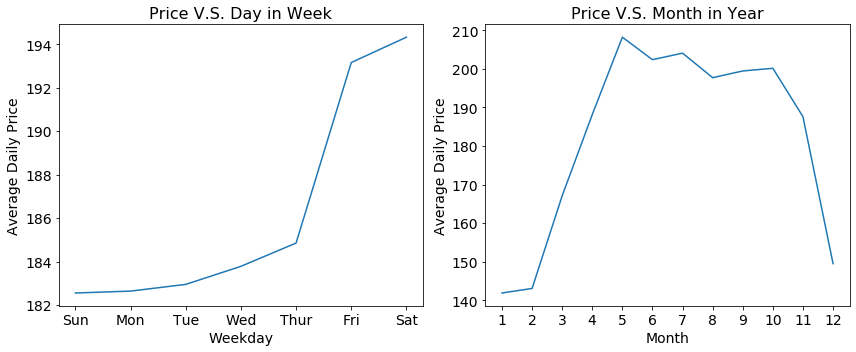

In [43]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(weekDay_order_index, weekDay_oder_value)
ax[0].set_xlabel('Weekday',fontsize=14)
ax[0].set_ylabel('Average Daily Price',fontsize=14)
ax[0].set_title('Price V.S. Day in Week',fontsize=16)
ax[0].set_xticklabels(['Sun','Mon','Tue','Wed','Thur','Fri','Sat'])
ax[0].tick_params(labelsize=14)

ax[1].plot(np.array(month_order_index)-1, month_oder_value)
ax[1].set_xticks(range(12), month_order_index)
ax[1].set_xlabel('Month',fontsize=14)
ax[1].set_ylabel('Average Daily Price',fontsize=14)
ax[1].set_title('Price V.S. Month in Year',fontsize=16)
ax[1].set_xticks(range(12))
ax[1].set_xticklabels(np.arange(1,13))
ax[1].tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('seasonality.png')

From the plot we can see that the price for Friday and Saturday are significantly higher than the other days in the week. Therefore, we created a categorical feature 'weekend' (including Friday and Saturday).

Moreover, each year from May to October is the peak, then comes (March, April, November), and the remaining are the slack season. Therefore we created a categorical feature 'peak_month', which has Peak (May to Oct), Middle(March, April, November) and Slack(Jan, Feb, Dec). 

In [45]:
df_clean['weekend'] = df_clean['dayWeek'].isin(['Friday', 'Saturday'])

In [46]:
def classify_month(x):
    if x in [5,6,7,8,9,10]:
        return 'Peak'
    elif x in[3,4,11]:
        return 'Middle'
    else:
        return 'Slack'

df_clean['peak_month'] = df_clean['month'].apply(classify_month)

In [47]:
date_boston = ['20181011','20181117','20181213','20190117','20190209','20190312',
               '20190415','20190519','20190614','20190714','20190819','20190922',
               '20191011']

pull_time_boston = np.array([datetime.strptime(x, '%Y%m%d') for x in date_boston])

date_cambridge = ['20181118','20181215','20190122','20190213','20190318',
                  '20190418','20190523','20190624','20190720','20190828','20190925',
                  '20191118']
pull_time_cambridge = np.array([datetime.strptime(x, '%Y%m%d') for x in date_cambridge])

In [48]:
def calculate_pull_length(t, city):
    if city == 'Boston':
        diff = (t - np.array(pull_time_boston))
    else:
        diff = (t - np.array(pull_time_cambridge))
    day_diff = np.array([x.days for x in diff])
    return day_diff[day_diff>=0][-1]

In [49]:
def calculate_pull_length(data):
    t = data['date']
    city = data['city']
    if city == 'boston':
        diff = (t - np.array(pull_time_boston))
    else:
        diff = (t - np.array(pull_time_cambridge))
    day_diff = np.array([x.days for x in diff])
    return day_diff[day_diff>=0][-1]

In [50]:
df_clean['pull_distance'] = df_clean.apply(calculate_pull_length, axis = 1)

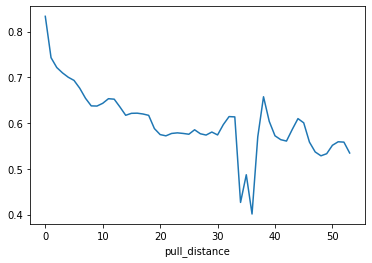

In [51]:
dayPullDistance= df_clean.groupby('pull_distance')['unavailable'].mean()
dayPullDistance.plot();

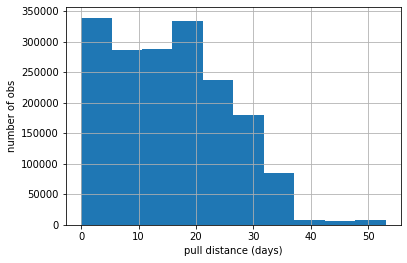

In [52]:
df_clean['pull_distance'].hist()
plt.xlabel('pull distance (days)')
plt.ylabel('number of obs');

From the number of obs vs pull distance we can see that, it's better for us to keep the records with pull distance <= 30 (which is reasonable espcially in our case).

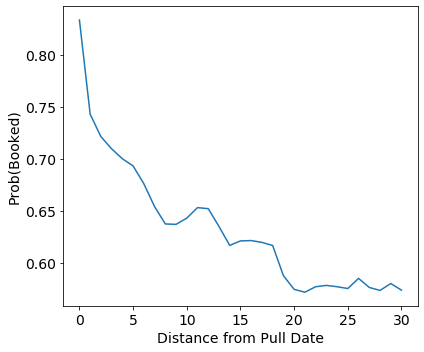

In [58]:
df_clean_pre = df_clean
df_clean = df_clean[df_clean.pull_distance <= 30]
dayPullDistance= df_clean.groupby('pull_distance')['unavailable'].mean()
plt.figure(figsize=(6,5))
dayPullDistance.plot()
plt.xlabel('Distance from Pull Date',fontsize=14)
plt.ylabel('Prob(Booked)',fontsize=14)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('pull_distance.png')


In [31]:
df_clean.to_csv('data/cleanData.csv', index = False)

In [57]:
not_features = ['listing_id','date','dayWeek','month','host_since','city', 'year', 'day']
df_model = df_clean.drop(not_features, axis = 1)
df_model.to_csv('data/modelData.csv', index = False)